In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error

import datetime

from arch import arch_model

import numpy.linalg as la
from pandas.tseries.offsets import BDay

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from joblib import Parallel, delayed

from tqdm import tqdm

In [2]:
df_clustered = pd.read_csv("knn-dataset.csv")
df_crsp = pd.read_csv('stock_daily.csv')
df_crsp['date'] = pd.to_datetime(df_crsp['date'])
df_crsp

,date,permno,ticker,prc,retx,shrout,cfacpr,vol,vwretd,vwretx
0,1975-01-02,23924,CFSR,-11.62500,0.000000,1591.0,2.0000,NaN,0.025240,0.025212
1,1975-01-02,23931,NSP,17.12500,0.070313,23233.0,4.0000,12300.0,0.025240,0.025212
2,1975-01-02,23975,CLRK,-21.00000,0.000000,1279.0,45.5625,NaN,0.025240,0.025212
3,1975-01-02,23990,ROH,47.87500,0.035135,12871.0,18.0000,4600.0,0.025240,0.025212
4,1975-01-02,24002,DEW,9.25000,0.000000,16487.0,1.5000,12200.0,0.025240,0.025212
...,...,...,...,...,...,...,...,...,...,...
88359665,2024-12-31,92396,ECH,25.04000,0.000000,18950.0,1.0000,67015.0,-0.003392,-0.003541
88359666,2024-12-31,92397,BKF,36.49050,-0.002550,1850.0,1.0000,2732.0,-0.003392,-0.003541
88359667,2024-12-31,92398,AIA,67.83000,-0.005571,10500.0,1.0000,38260.0,-0.003392,-0.003541
88359668,2024-12-31,92402,MSCI,600.01001,0.000600,78371.0,1.0000,223964.0,-0.003392,-0.003541


In [3]:
# Only keeping the permno that exist in df_clustered 
# -------------------------------------------------------------
# Create a reference key from df_clustered
valid_keys = df_clustered[['permno', 'trading_start']].drop_duplicates()

# Assign trading_start to df_crsp
df_crsp['trading_start'] = df_crsp['date'].dt.to_period('Q').dt.start_time

valid_keys['trading_start'] = pd.to_datetime(valid_keys['trading_start'])
df_crsp['trading_start'] = pd.to_datetime(df_crsp['trading_start'])

# Keep only CRSP rows for stocks in df_clustered for that trading quarter
df_crsp_filtered = pd.merge(df_crsp, valid_keys, on=['permno', 'trading_start'], how='inner')
df_crsp_filtered

,date,permno,ticker,prc,retx,shrout,cfacpr,vol,vwretd,vwretx,trading_start
0,1975-04-01,22592,MMM,51.12500,0.002451,114200.0,9.824557,77900.0,-0.007779,-0.007821,1975-04-01
1,1975-04-01,22752,MRK,73.75000,-0.026403,75389.0,40.008190,47200.0,-0.007779,-0.007821,1975-04-01
2,1975-04-01,23819,HAL,145.50000,0.000000,19167.0,25.056250,16300.0,-0.007779,-0.007821,1975-04-01
3,1975-04-01,25013,SGP,60.12500,0.002083,53929.0,32.000000,29200.0,-0.007779,-0.007821,1975-04-01
4,1975-04-01,25478,CRK,34.00000,0.018727,8000.0,6.000000,15400.0,-0.007779,-0.007821,1975-04-01
...,...,...,...,...,...,...,...,...,...,...,...
14830463,2024-12-31,92245,AROC,24.89000,0.000000,175154.0,1.000000,1007467.0,-0.003392,-0.003541,2024-10-01
14830464,2024-12-31,92293,TDC,31.15000,0.004191,95700.0,1.000000,828475.0,-0.003392,-0.003541,2024-10-01
14830465,2024-12-31,92322,ULTA,434.92999,-0.001079,46569.0,1.000000,465628.0,-0.003392,-0.003541,2024-10-01
14830466,2024-12-31,92326,CVI,18.74000,0.009698,100531.0,1.000000,1063685.0,-0.003392,-0.003541,2024-10-01


In [4]:
df_clustered['trading_start'] = pd.to_datetime(df_clustered['trading_start'])

df_merged = pd.merge(
    df_crsp_filtered,
    df_clustered[['permno', 'trading_start', 'group_id']],
    on=['permno', 'trading_start'],
    how='left'
)
df_merged

,date,permno,ticker,prc,retx,shrout,cfacpr,vol,vwretd,vwretx,trading_start,group_id
0,1975-04-01,22592,MMM,51.12500,0.002451,114200.0,9.824557,77900.0,-0.007779,-0.007821,1975-04-01,1975-Q1-07
1,1975-04-01,22752,MRK,73.75000,-0.026403,75389.0,40.008190,47200.0,-0.007779,-0.007821,1975-04-01,1975-Q1-04
2,1975-04-01,23819,HAL,145.50000,0.000000,19167.0,25.056250,16300.0,-0.007779,-0.007821,1975-04-01,1975-Q1-08
3,1975-04-01,25013,SGP,60.12500,0.002083,53929.0,32.000000,29200.0,-0.007779,-0.007821,1975-04-01,1975-Q1-04
4,1975-04-01,25478,CRK,34.00000,0.018727,8000.0,6.000000,15400.0,-0.007779,-0.007821,1975-04-01,1975-Q1-04
...,...,...,...,...,...,...,...,...,...,...,...,...
14831791,2024-12-31,92245,AROC,24.89000,0.000000,175154.0,1.000000,1007467.0,-0.003392,-0.003541,2024-10-01,2024-Q3-10
14831792,2024-12-31,92293,TDC,31.15000,0.004191,95700.0,1.000000,828475.0,-0.003392,-0.003541,2024-10-01,2024-Q3-00
14831793,2024-12-31,92322,ULTA,434.92999,-0.001079,46569.0,1.000000,465628.0,-0.003392,-0.003541,2024-10-01,2024-Q3-08
14831794,2024-12-31,92326,CVI,18.74000,0.009698,100531.0,1.000000,1063685.0,-0.003392,-0.003541,2024-10-01,2024-Q3-10


In [5]:
df_merged['vol'] = df_merged['vol'].fillna(0) / 100           # ← changed
# rolling 20 day average volumne
df_merged['adv20'] = (df_merged.groupby('permno')['vol']
                      .rolling(20, min_periods=1).mean()
                      .reset_index(level=0, drop=True))

# adjusted price
df_merged['adj_prc'] = df_merged['prc'] / df_merged['cfacpr']

In [6]:
# Replace inf and -inf with NaN
df_merged['adj_prc'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN adjusted prices
df_merged = df_merged.dropna(subset=['adj_prc'])

df_merged['adj_prc'].describe() # confirm cleanup worked

# Ensure No Negative Prices (Exclude Returns on Delisted Days)
df_merged = df_merged[df_merged['adj_prc'] > 0]

# sort values
df_merged = df_merged.sort_values(by=['permno', 'date']).reset_index(drop=True)

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_5258/300961047.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['adj_prc'].replace([np.inf, -np.inf], np.nan, inplace=True)


## Analysis

In [7]:
# basic stats
df_merged['adj_prc'].describe()

count    1.338103e+07
mean     2.524808e+03
std      1.127241e+05
min      1.497396e-02
25%      7.650000e+00
50%      1.799000e+01
75%      3.898000e+01
max      6.312500e+07
Name: adj_prc, dtype: float64

Number of tickers with full span coverage: 459


/Users/komalniraula/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


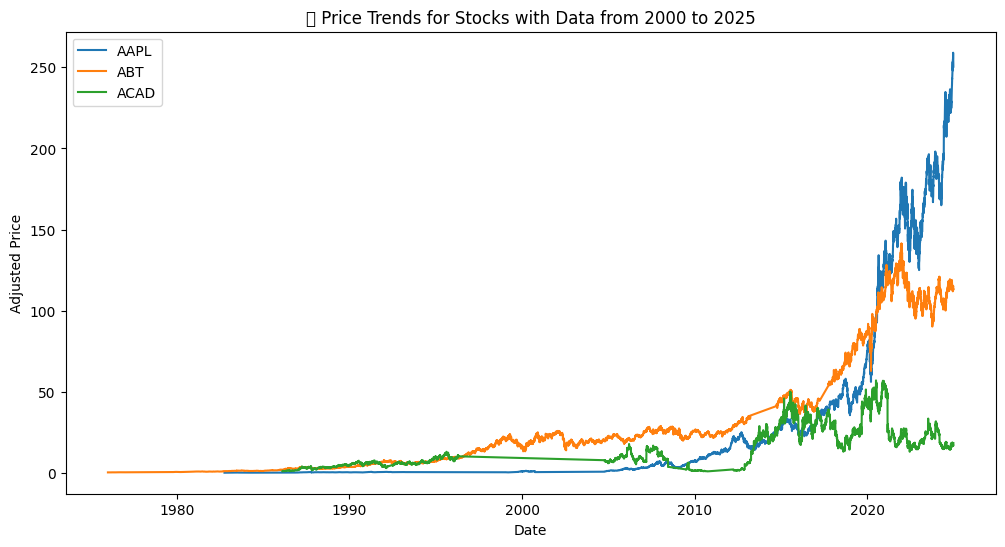

In [8]:
# Identify tickers with data from BOTH 2000 and 2025
tickers_with_full_span = (
    df_merged.groupby('ticker')['date']
    .agg(['min', 'max'])
    .query("min <= '2000-01-01' and max >= '2024-12-30'")
    .index.tolist()
)

print(f"Number of tickers with full span coverage: {len(tickers_with_full_span)}")

# Visualize Sample from These Tickers
sample_tickers = tickers_with_full_span[2:5]  # Select first 5 for visualization

plt.figure(figsize=(12, 6))
for ticker in sample_tickers:
    subset = df_merged[df_merged['ticker'] == ticker]
    plt.plot(subset['date'], subset['adj_prc'], label=ticker)

plt.legend()
plt.title("📈 Price Trends for Stocks with Data from 2000 to 2025")
plt.xlabel("Date")
plt.ylabel("Adjusted Price")
plt.show()

## 📚 **Volatility Analysis – Rolling vs. GARCH**

Understanding volatility is critical in portfolio management and risk assessment.  
In this section, we compare two approaches:

1. 📏 **Rolling (Historical) Volatility:**  
   - Simple method that calculates standard deviation over a fixed time window (e.g., last 20 days).
   - Assumes volatility changes slowly and doesn't account for sudden market shocks.

2. 📈 **GARCH (Generalized Autoregressive Conditional Heteroskedasticity):**  
   - Advanced model that dynamically estimates volatility based on past volatility and past shocks.
   - Captures **volatility clustering**, which is common in financial markets (periods of calm followed by high turbulence).

---

In [9]:
# 20-day rolling volatility
df_merged['rolling_vol_20d_daily'] = (
    df_merged.groupby('permno')['retx']
    .rolling(window=20, min_periods=15) # looks at past 20 days returns to calculate today's volatility
    .std()
    .reset_index(level=0, drop=True)
)


# Calculate 20-Day Rolling Volatility (Annualized)
df_merged['rolling_vol_20d'] = (
    df_merged.groupby('permno')['retx']
    .rolling(window=20, min_periods=15) # looks at past 20 days returns to calculate today's volatility
    .std()
    .reset_index(level=0, drop=True) * np.sqrt(252)  # Annualize
)

In [10]:
def calculate_garch_vol(series):
    if series.dropna().shape[0] < 100:
        return pd.Series(index=series.index, data=np.nan) # if there's not enough data (less than 100 days), skip calculation
    try:
        # prepare model, we are multiplying by 100 to express return in percentage
        model = arch_model(series.dropna() * 100, vol='Garch', p=1, q=1, dist='normal')

        # fit garch model to estimate volatility
        res = model.fit(disp='off')

        # gets model predicted volatility patterns
        forecasts = res.conditional_volatility / 100  # Scale back to normal scale

        forecasts = forecasts.shift(1)  # Use today's forecast for tomorrow's decision (avoid lookahead bias)
        
        forecasts.index = series.dropna().index # align forecast back to original dates
        return forecasts.reindex(series.index) # reindex to fill missing dates
    except:
        return pd.Series(index=series.index, data=np.nan)

# Compute GARCH Volatility Safely and Align Index
garch_vol_series = (
    df_merged.groupby('permno')['retx']
    .apply(calculate_garch_vol)
    .reset_index(level=0, drop=True)  # This flattens the index to match df_merged
)

# Now safely assign to the dataframe
df_merged['garch_vol'] = garch_vol_series

df_merged['garch_vol_annualized'] = df_merged['garch_vol'] * np.sqrt(252) # annualized

/Users/komalniraula/myenv/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/komalniraula/myenv/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/komalniraula/myenv/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/komalniraula/myenv/lib/python3.13/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.

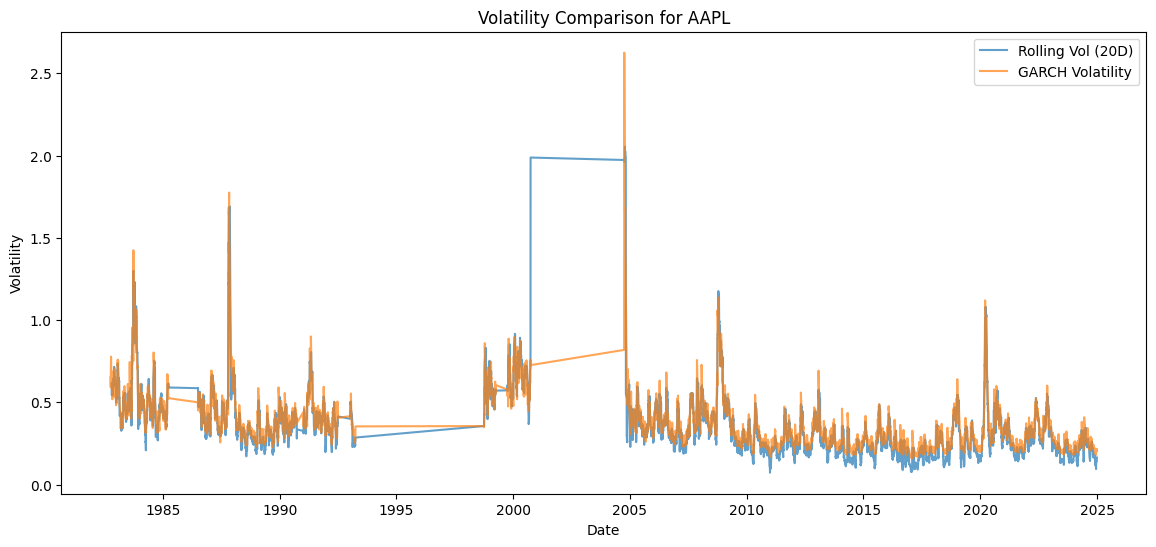

In [11]:
# Select a sample ticker for visualization
sample_ticker = tickers_with_full_span[2]  # Pick first ticker with full span

subset = df_merged[df_merged['ticker'] == sample_ticker]

plt.figure(figsize=(14, 6))
plt.plot(subset['date'], subset['rolling_vol_20d'], label='Rolling Vol (20D)', alpha=0.7)
plt.plot(subset['date'], subset['garch_vol_annualized'], label='GARCH Volatility', alpha=0.7)
plt.title(f"Volatility Comparison for {sample_ticker}")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [12]:
## to compare which prediction is better

# Calculate Future Realized Volatility (5-Day)
df_merged['realized_vol_5d'] = (
    df_merged.groupby('permno')['retx']
    .rolling(window=5, min_periods=5)
    .std()   # standard deviation (avg volatility of next 5 days)
    .shift(-5)  # Look ahead 5 days
    .reset_index(level=0, drop=True)
)

In [13]:
valid_data = df_merged.dropna(subset=['garch_vol', 'rolling_vol_20d_daily', 'realized_vol_5d'])

mse_garch = mean_squared_error(valid_data['realized_vol_5d'], valid_data['garch_vol'])
mse_rolling = mean_squared_error(valid_data['realized_vol_5d'], valid_data['rolling_vol_20d_daily'])

print(f"📉 GARCH Forecast MSE: {mse_garch:.6f}")
print(f"📉 Rolling Volatility MSE: {mse_rolling:.6f}")

📉 GARCH Forecast MSE: 0.000882
📉 Rolling Volatility MSE: 0.000918


#### 📊 **Forecast Accuracy Comparison for AAPL**

| Model         | MSE (Lower is Better) |
|----------------|-----------------------|
| GARCH Volatility | 0.000882             |
| Rolling Volatility | 0.000918           |

- GARCH provided slightly better predictions of future volatility, but the difference is very small.



### Now let's look over entire stocks

**Analyze**:
   - For how many stocks does GARCH volatility provide better predictions?
   - For how many stocks does Rolling volatility perform better?
   - Compute the **average MSE** for both methods to assess overall performance.

This will help to decide which volatility model performs better at the stock level and across the entire market.

In [14]:
# Calculate MSE for Each Stock (permno)
mse_results = []

for permno, group in df_merged.groupby('permno'):
    data = group.dropna(subset=['garch_vol', 'rolling_vol_20d', 'realized_vol_5d'])
    
    if not data.empty:
        mse_garch = mean_squared_error(data['realized_vol_5d'], data['garch_vol'])
        mse_rolling = mean_squared_error(data['realized_vol_5d'], data['rolling_vol_20d'])
        
        mse_results.append({'permno': permno, 'mse_garch': mse_garch, 'mse_rolling_20d': mse_rolling})

# Convert to DataFrame and Merge with Main Data
mse_df = pd.DataFrame(mse_results)
df_mse_summary = mse_df.copy()  # This dataframe stores one row per stock with MSE values

In [15]:
# Analyze Results
garch_better_count = (df_mse_summary['mse_garch'] < df_mse_summary['mse_rolling_20d']).sum()
rolling_better_count = (df_mse_summary['mse_rolling_20d'] <= df_mse_summary['mse_garch']).sum()

avg_mse_garch = df_mse_summary['mse_garch'].mean()
avg_mse_rolling = df_mse_summary['mse_rolling_20d'].mean()

print(f"📈 Number of stocks where GARCH performed better: {garch_better_count}")
print(f"📉 Number of stocks where Rolling 20D performed better: {rolling_better_count}")
print(f"\n✅ Average MSE - GARCH: {avg_mse_garch:.6f}")
print(f"✅ Average MSE - Rolling 20D: {avg_mse_rolling:.6f}")

📈 Number of stocks where GARCH performed better: 10828
📉 Number of stocks where Rolling 20D performed better: 0

✅ Average MSE - GARCH: 0.001301
✅ Average MSE - Rolling 20D: 0.639405


In [16]:
unique_stocks = df_merged['permno'].nunique()
print(f"📊 Total Unique Stocks in the Dataset: {unique_stocks}")

📊 Total Unique Stocks in the Dataset: 11827


In [17]:
df_mse_summary.columns

Index(['permno', 'mse_garch', 'mse_rolling_20d'], dtype='object')

### 📖 **Volatility Forecast Evaluation – Final Results**

Out of a total of **11,827 unique stocks** in the dataset, only **10,828 stocks had sufficient and valid data** to perform a meaningful comparison between GARCH and Rolling 20-Day volatility forecasts.  
The remaining stocks lacked enough historical price data or had missing values required for computing as:
- GARCH Volatility (requires at least 100 valid return observations),
- Rolling 20-Day Volatility (requires at least 15 observations),
- Future Realized Volatility (needs returns data for the next 5 days).



#### 📊 **Results Summary:**

| Metric                              | Value        |
|--------------------------------------|--------------|
| Stocks Where GARCH Performed Better  | **10,828**   |
| Stocks Where Rolling Performed Better | **0**        |
| Average MSE – GARCH                  | **0.001301** |
| Average MSE – Rolling 20D            | **0.639405** |



#### Let's compare GARCH with rolling vol for 5, 10 and 20 days

In [18]:
def calculate_mse_per_stock(df, horizons=[5, 10, 20], realized_col='realized_vol_5d'):
    mse_results = []

    for permno, group in df.groupby('permno'):
        mse_entry = {'permno': permno}

        # Calculate GARCH MSE if possible
        data_garch = group.dropna(subset=['garch_vol', realized_col])
        if not data_garch.empty:
            mse_entry['mse_garch'] = mean_squared_error(data_garch[realized_col], data_garch['garch_vol'])

        # Calculate Rolling MSEs for each horizon if possible
        for h in horizons:
            rolling_col = f'rolling_vol_{h}d_daily'
            data_rolling = group.dropna(subset=[rolling_col, realized_col])

            if not data_rolling.empty:
                mse_entry[f'mse_rolling_{h}d'] = mean_squared_error(data_rolling[realized_col], data_rolling[rolling_col])

        mse_results.append(mse_entry)

    return pd.DataFrame(mse_results)

# 📌 Run the MSE Calculation
mse_summary = calculate_mse_per_stock(df_merged, horizons=[5, 10, 20])

# 📈 Analyze and Print Results Like Before
def analyze_mse_results(df_mse_summary, horizons=[5, 10, 20]):
    for h in horizons:
        rolling_col = f'mse_rolling_{h}d'

        if rolling_col not in df_mse_summary.columns:
            print(f"⚠️ Rolling MSE for {h} days not found.")
            continue

        valid_data = df_mse_summary.dropna(subset=['mse_garch', rolling_col])

        garch_better_count = (valid_data['mse_garch'] < valid_data[rolling_col]).sum()
        rolling_better_count = (valid_data[rolling_col] <= valid_data['mse_garch']).sum()

        avg_mse_garch = valid_data['mse_garch'].mean()
        avg_mse_rolling = valid_data[rolling_col].mean()

        print(f"--- Horizon: {h} Days ---")
        print(f"📈 Number of stocks where GARCH performed better: {garch_better_count}")
        print(f"📉 Number of stocks where Rolling {h}D performed better: {rolling_better_count}")
        print(f"✅ Average MSE - GARCH: {avg_mse_garch:.6f}")
        print(f"✅ Average MSE - Rolling {h}D: {avg_mse_rolling:.6f}\n")

# 📌 Run Analysis
analyze_mse_results(mse_summary, horizons=[5, 10, 20])

KeyError: ['rolling_vol_5d_daily']

In [ ]:
def calculate_and_analyze_mse(df, horizons=[5, 10, 20], realized_col='realized_vol_5d'):
    for h in horizons:
        rolling_col = f'rolling_vol_{h}d'
        mse_results = []

        # Exact behavior: Only calculate when all required columns are available
        for permno, group in df.groupby('permno'):
            data = group.dropna(subset=['garch_vol', rolling_col, realized_col])

            if not data.empty:
                mse_garch = mean_squared_error(data[realized_col], data['garch_vol'])
                mse_rolling = mean_squared_error(data[realized_col], data[rolling_col])
                mse_results.append({
                    'permno': permno,
                    'mse_garch': mse_garch,
                    f'mse_rolling_{h}d': mse_rolling
                })

        # Create MSE Summary DataFrame
        mse_df = pd.DataFrame(mse_results)

        # Analyze Results
        garch_better_count = (mse_df['mse_garch'] < mse_df[f'mse_rolling_{h}d']).sum()
        rolling_better_count = (mse_df[f'mse_rolling_{h}d'] <= mse_df['mse_garch']).sum()

        avg_mse_garch = mse_df['mse_garch'].mean()
        avg_mse_rolling = mse_df[f'mse_rolling_{h}d'].mean()

        print(f"--- Horizon: {h} Days ---")
        print(f"📈 Number of stocks where GARCH performed better: {garch_better_count}")
        print(f"📉 Number of stocks where Rolling {h}D performed better: {rolling_better_count}")
        print(f"✅ Average MSE - GARCH: {avg_mse_garch:.6f}")
        print(f"✅ Average MSE - Rolling {h}D: {avg_mse_rolling:.6f}\n")

# 📌 Example Usage:
calculate_and_analyze_mse(df_merged, horizons=[5, 10, 20])

### 📌 **Conclusion & Model Selection:**

- GARCH Volatility provided consistently lower forecast errors across all stocks with valid data.
- Rolling 5, 10, 20-Day volatility not only performed worse but had significantly higher average MSE, indicating poor predictive accuracy.
- ✅ **Decision:**  
We will use **GARCH Volatility** for further modeling and trading strategy development, as it has demonstrated superior predictive power in forecasting future realized volatility.



> 📖 *Note: This choice aligns with our objective of improving risk-adjusted returns through better volatility estimation and position sizing.*

## 📖 **Ornstein-Uhlenbeck (OU) Return Forecast Analysis**

Now that we have determined GARCH volatility provides better risk estimation, we evaluate the predictive power of the **Ornstein-Uhlenbeck (OU) process** for return forecasting.



#### 📌 **What We Have Implemented**

We use the **Discrete-Time OU Forecast Formula** to estimate the expected return for the next day:

$$
\mathbb{E}[X_{t+1}] = X_t \cdot e^{-\theta} + \mu \cdot \left(1 - e^{-\theta}\right)
$$



- $X_t$: This is the **previous day's return**, taken from the `retx` column.
- We calculate $\theta$ and $\mu$ using the `estimate_ou_params` function.

| Parameter    | Meaning                 | How We Calculated and Used It |
|---------------|-------------------------|------------------------------|
| $\theta$    | **Speed of mean reversion**. Controls **how quickly returns move back toward their long-term average**. | Calculated **individually for each stock** using historical returns. Estimated via linear regression: first compute $\beta$ (coefficient) from $X_t = \beta X_{t-1} + c$, then calculate $\theta = -\ln(\beta)$. |
| $\mu$       | **Long-term mean return**. This is the return level each stock tends to revert to over time. | Calculated **individually for each stock** using $\mu = \frac{c}{1 - \beta}$, where $c$ is the intercept from the previous regression. |

- These parameters are computed **separately for each stock** based on its historical return data.


After calculating these parameters, we forecast the next day's return and store it in the `ou_forecast_return` column using:

```python
df_merged['ou_forecast_return'] = (
    df_merged['retx'].shift(1) * np.exp(-df_merged['theta']) +
    df_merged['mu'] * (1 - np.exp(-df_merged['theta']))
)
```

#### **Explanation of `np.exp(-θ)` in the Formula**

- `np.exp(-θ)` calculates the mathematical term $e^{-\theta}$.
- This term determines **how much weight is given to the previous day's return ($X_t$)** in the forecast.
    - If $\theta$ is small, $e^{-\theta}$ is close to 1, and the forecast relies more on the previous return.
    - If $\theta$ is large, $e^{-\theta}$ becomes small, and the forecast relies more on the long-term mean $\mu$.

- In simple terms:
    - A **small $\theta$** means slow mean reversion, so the forecast stays closer to yesterday’s return.
    - A **large $\theta$** means fast mean reversion, so the forecast moves quickly toward the historical average return.





In [ ]:
# OU Parameter Estimation Function
def estimate_ou_params(series):
    series = series.dropna()
    if len(series) < 30:
        return None, None  # Insufficient data

    x_lag = series.shift(1).dropna()
    x_current = series.loc[x_lag.index]

    X = np.vstack([x_lag.values, np.ones(len(x_lag))]).T
    beta, c = np.linalg.lstsq(X, x_current.values, rcond=None)[0]

    if beta <= 0 or beta >= 1:
        return None, None  # Invalid beta, no meaningful mean reversion

    θ = -np.log(beta)  # Speed of mean reversion
    μ = c / (1 - beta)  # Long-term mean level

    return θ, μ

# Apply OU Estimation for Each Stock
ou_results = []

for permno, group in df_merged.groupby('permno'):
    ret_series = group['retx']
    θ, μ = estimate_ou_params(ret_series)
    if θ is not None and μ is not None:
        ou_results.append({'permno': permno, 'theta': θ, 'mu': μ})

ou_df = pd.DataFrame(ou_results)

In [ ]:
# Merge OU Parameters Back to Main Data
df_merged = df_merged.merge(ou_df, on='permno', how='left')

# OU Return Forecast Formula: E[x_t+1] = x_t * exp(-θ) + μ * (1 - exp(-θ))
df_merged['ou_forecast_return'] = (
    df_merged['retx'].shift(1) * np.exp(-df_merged['theta']) +
    df_merged['mu'] * (1 - np.exp(-df_merged['theta']))
)

#### OU based z-score vs classical z-score (based on SD)

In [ ]:
# 📌 Calculate OU-Based Z-Score
df_merged['z_ou'] = (
    (df_merged['ou_forecast_return'] - df_merged['retx']) / df_merged['garch_vol']
)

In [ ]:
def evaluate_zscore_with_ou(df, horizons=[5, 10, 20]):
    results = []
    
    for h in horizons:
        # 📌 Calculate Rolling Mean and Std Dev for Classical Z-Score
        rolling_mean = (
            df.groupby('permno')['retx']
            .rolling(window=h, min_periods=int(h * 0.75))
            .mean()
            .reset_index(level=0, drop=True)
        )
        
        rolling_std = (
            df.groupby('permno')['retx']
            .rolling(window=h, min_periods=int(h * 0.75))
            .std()
            .reset_index(level=0, drop=True)
        )
        
        # Classical Z-Score for Current Horizon
        z_col = f'z_classical_{h}d'
        df[z_col] = (df['retx'] - rolling_mean) / rolling_std
        df[f'{z_col}_shifted'] = df[z_col].shift(1)  # Apply shift to avoid lookahead bias

        # Ensure OU-Based Z-Score is Shifted
        if 'z_ou_shifted' not in df.columns:
            df['z_ou_shifted'] = df['z_ou'].shift(1)

        # Prepare Valid Dataset with Both Classical and OU-Based Z-Scores Available
        valid = df.dropna(subset=[f'{z_col}_shifted', 'z_ou_shifted', 'future_return_1d'])

        # Calculate Hit Rates
        hit_rate_classical = (np.sign(valid[f'{z_col}_shifted']) == np.sign(valid['future_return_1d'])).mean()
        hit_rate_ou = (np.sign(valid['z_ou_shifted']) == np.sign(valid['future_return_1d'])).mean()

        results.append({
            'Hit Rate Classical (%)': hit_rate_classical * 100,
            'Hit Rate OU-Based (%)': hit_rate_ou * 100,
            'Unique Permnos': valid['permno'].nunique()
        })

    return pd.DataFrame(results)

# Ensure Future Return is Calculated
df_merged['future_return_1d'] = df_merged.groupby('permno')['retx'].shift(-1)

# Run Evaluation
evaluation_df = evaluate_zscore_with_ou(df_merged, horizons=[5, 10, 20])

evaluation_df

#### 📌 **Incorporating Volatility into OU Forecast**

In the deterministic OU forecast, we calculated only the expected mean return using:

$$
\mathbb{E}[X_{t+1}] = X_t \cdot e^{-\theta} + \mu \cdot \left(1 - e^{-\theta}\right)
$$

However, this ignores the randomness or uncertainty in returns.  
To introduce volatility into the forecast, we simulate a random shock using the following stochastic version of the OU process:

$$
X_{t+1} = \mathbb{E}[X_{t+1}] + \sigma \cdot \sqrt{1 - e^{-2\theta}} \cdot \varepsilon
$$

Where:
- $\mathbb{E}[X_{t+1}]$: Deterministic OU forecast (`ou_forecast_return`).
- $\sigma$: Volatility estimate, using **GARCH volatility** (`garch_vol`).
- $\theta$: Mean reversion speed parameter.
- $\varepsilon \sim \mathcal{N}(0, 1)$: A random value drawn from a standard normal distribution.



- `np.random.normal(0, 1, len(df_merged))` generates random shocks for each time period.
- `np.sqrt(1 - np.exp(-2 * df_merged['theta']))` adjusts the variance to account for discrete time steps.
- This creates a more realistic forecast by adding randomness, representing possible price movement uncertainty around the mean forecast.

The final stochastic forecast is stored in `ou_forecast_with_volatility`:

```python
df_merged['ou_forecast_with_volatility'] = (
    df_merged['ou_forecast_return'] + 
    df_merged['garch_vol'] * np.sqrt(1 - np.exp(-2 * df_merged['theta'])) * np.random.normal(0, 1, len(df_merged))
)


In [ ]:
# Assuming you already have ou_forecast_return, theta, and GARCH volatility columns

np.random.seed(42)  # For reproducibility

df_merged['ou_forecast_with_volatility'] = (
    df_merged['ou_forecast_return'] + 
    df_merged['garch_vol'] * np.sqrt(1 - np.exp(-2 * df_merged['theta'])) * np.random.normal(0, 1, len(df_merged))
)

In [ ]:
df_merged['z_ou_with_volatility'] = (
    (df_merged['ou_forecast_with_volatility'] - df_merged['retx']) / df_merged['garch_vol']
)

### 📖 **Evaluating Hit Rate for Trading Signals**

In this analysis, we evaluate the effectiveness of our trading signals by calculating the **Hit Rate** across different forecasting methods and time horizons.



#### 📌 **What Is Hit Rate?**

- Hit Rate measures the **percentage of times the trading signal correctly predicts the direction of future returns**.
- It focuses **only on the direction (up or down)**, not the magnitude of returns.
- A higher Hit Rate indicates that the signal is better at predicting whether the return will be positive or negative.

$$
\text{Hit Rate} = \frac{\text{Number of Correct Predictions}}{\text{Total Predictions}}
$$



We will use **Z-Scores** to generate signals for hit rate prediction.  
- A **positive Z-Score** indicates that the stock is expected to **rise** (suggesting a long position).  
- A **negative Z-Score** indicates that the stock is expected to **fall** (suggesting a short position).  

By comparing the predicted direction from Z-Scores with the actual future return, we can measure how many predictions were correct and how many were wrong.



#### 📚 **Z-Scores We Are Comparing:**



#### 1️⃣ **Classical Z-Score**

- Formula:

$$
Z_{\text{Classical}} = \frac{X_t - \mu_{\text{rolling}}}{\sigma_{\text{rolling}}}
$$

- Where:
  - $X_t$ = Current return (`retx`).
  - $\mu_{\text{rolling}}$ = Rolling mean of returns over a defined horizon (e.g., 5, 10, 20 days).
  - $\sigma_{\text{rolling}}$ = Rolling standard deviation of returns over the same horizon.



#### 2️⃣ **OU-Based Z-Score (Deterministic)**

- Formula:

$$
Z_{\text{OU}} = \frac{\mathbb{E}[X_{t+1}] - X_t}{\text{Volatility Estimate}}
$$

- Where:
  - $\mathbb{E}[X_{t+1}]$ = Forecasted return using the OU model (deterministic forecast).
    - Computed as:

    $$
    \mathbb{E}[X_{t+1}] = X_t \cdot e^{-\theta} + \mu \cdot \left(1 - e^{-\theta}\right)
    $$

  - $X_t$ = Current return (`retx`).
  - $\theta$ = Speed of mean reversion.
  - $\mu$ = Long-term average return (mean-reversion level).
  - Volatility Estimate = Typically GARCH-based volatility estimate.


#### 3️⃣ **OU-Based Z-Score (With Volatility)**

- Formula:

$$
Z_{\text{OU, Stochastic}} = \frac{X_{t+1}^{\text{stochastic}} - X_t}{\text{Volatility Estimate}}
$$

- Where:
  - $X_{t+1}^{\text{stochastic}} = \mathbb{E}[X_{t+1}] + \sigma \cdot \sqrt{1 - e^{-2\theta}} \cdot \varepsilon$
  - $\varepsilon \sim \mathcal{N}(0, 1)$ is a random shock (introduces randomness to the forecast).
  - $\sigma$ = GARCH-based volatility estimate.



By calculating and comparing these Z-Scores, we can assess how well each method predicts the direction of returns, using Hit Rate as the evaluation metric.

---


In [ ]:
def evaluate_zscore_with_ou(df, horizons=[5, 10, 20]):
    results = []
    
    for h in horizons:
        # 📌 Calculate Rolling Mean and Std Dev for Classical Z-Score
        rolling_mean = (
            df.groupby('permno')['retx']
            .rolling(window=h, min_periods=int(h * 0.75))
            .mean()
            .reset_index(level=0, drop=True)
        )
        
        rolling_std = (
            df.groupby('permno')['retx']
            .rolling(window=h, min_periods=int(h * 0.75))
            .std()
            .reset_index(level=0, drop=True)
        )
        
        # 📌 Classical Z-Score for Current Horizon
        z_col = f'z_classical_{h}d'
        df[z_col] = (df['retx'] - rolling_mean) / rolling_std
        df[f'{z_col}_shifted'] = df[z_col].shift(1)  # Avoid lookahead bias

        # 📌 Ensure OU-Based Z-Scores Are Shifted
        df['z_ou_shifted'] = df['z_ou'].shift(1)
        df['z_ou_with_volatility_shifted'] = df['z_ou_with_volatility'].shift(1)

        # 📌 Prepare Valid Dataset with All Required Columns
        valid = df.dropna(subset=[
            f'{z_col}_shifted', 
            'z_ou_shifted', 
            'z_ou_with_volatility_shifted', 
            'future_return_1d'
        ])

        # 📈 Calculate Hit Rates (Direction Prediction Accuracy)
        hit_rate_classical = (np.sign(valid[f'{z_col}_shifted']) == np.sign(valid['future_return_1d'])).mean()
        hit_rate_ou_det = (np.sign(valid['z_ou_shifted']) == np.sign(valid['future_return_1d'])).mean()
        hit_rate_ou_stochastic = (np.sign(valid['z_ou_with_volatility_shifted']) == np.sign(valid['future_return_1d'])).mean()

        result_row = {
            'Horizon (Days)': h,
            'Hit Rate Classical (%)': hit_rate_classical * 100,
            'Hit Rate OU (Deterministic) (%)': hit_rate_ou_det * 100,
            'Hit Rate OU (With Volatility) (%)': hit_rate_ou_stochastic * 100,
            'Unique Permnos': valid['permno'].nunique()
        }

        results.append(result_row)

    return pd.DataFrame(results)

# Ensure Future Return is Calculated
df_merged['future_return_1d'] = df_merged.groupby('permno')['retx'].shift(-1)

# Run Evaluation
evaluation_df = evaluate_zscore_with_ou(df_merged, horizons=[5, 10, 20])

evaluation_df

#### **Final Decision: Use Classical Z-Score with 5-Day Horizon**

Based on our evaluation, we observed that the **Classical Z-Score with a 5-day horizon** performs almost as well as the OU-based Z-Scores in terms of directional prediction (Hit Rate), while being much simpler to compute and implement.

However, the hit rate is only 46.58% of time, meaning the z-score direction prediction is only correct for 46.58% of the time. 



### **Analyzing hit rate for Modeling**
Now, that we have decided to take classical z-score let's analyze it to form a better strategy

#### Let's begin with hit rate based on permno (individual security)

In [ ]:
# Ensure Z-Score and future return columns are properly shifted and available
df_merged['z_classical_5d_shifted'] = df_merged['z_classical_5d'].shift(1)
df_merged['future_return_1d'] = df_merged.groupby('permno')['retx'].shift(-1)

# Filter out rows with missing values
valid_data = df_merged.dropna(subset=['z_classical_5d_shifted', 'future_return_1d'])

# Calculate Hit Indicator: 1 if correct direction, 0 otherwise
valid_data['hit_correct'] = (np.sign(valid_data['z_classical_5d_shifted']) == 
                             np.sign(valid_data['future_return_1d'])).astype(int)

# Calculate Hit Rate per permno
hit_rate_per_stock = valid_data.groupby('permno')['hit_correct'].mean().reset_index()
hit_rate_per_stock.rename(columns={'hit_correct': 'Hit Rate'}, inplace=True)

# Sort Stocks by Hit Rate (Descending)
hit_rate_per_stock = hit_rate_per_stock.sort_values('Hit Rate', ascending=False)

hit_rate_per_stock.head(10)  # Top 10 stocks with highest Hit Rate

In [ ]:
# Count number of permnos with Hit Rate greater than 70%
num_high_hit_rate_stocks = (hit_rate_per_stock['Hit Rate'] > 0.50).sum()

print(f"Number of stocks with Hit Rate > 50%: {num_high_hit_rate_stocks}")

#### 📖 **Does Speed and Long-Term Mean Have Any Relationship with Hit Rate?**

The **speed** ($\theta$) and **long-term mean** ($\mu$) are parameters in the **Ornstein-Uhlenbeck (OU) forecast**, which models mean-reverting behavior of stock returns.



- **$X_t$ (Current Value):**  
  - In our implementation, $X_t$ represents the **daily price return excluding dividends**, calculated from stock price changes.  
  - This is the value from the `retx` column in the dataset.



- **Speed ($\theta$):**  
  - Represents **how quickly returns revert to their long-term mean**.  
  - Higher $\theta$ → Faster reversion.  
  - Calculated from the regression equation:  

    $$
    \theta = -\ln(\beta)
    $$  

    where $\beta$ is the slope coefficient from the regression equation:

    $$
    X_t = \beta X_{t-1} + c
    $$  

- **Long-Term Mean ($\mu$):**  
  - Represents the **average return level** the stock tends to revert to over time.  
  - Calculated as:  

    $$
    \mu = \frac{c}{1 - \beta}
    $$  

    where $c$ is the intercept from the same regression.



Let's try to visualize their relationships with Hit Rate to check if we can incorporate them into our trading strategy for improving signal effectiveness.

In [ ]:
hit_analysis_df = hit_rate_per_stock.merge(ou_df, on='permno', how='inner')
hit_analysis_df

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=hit_analysis_df, x='theta', y='Hit Rate')
plt.title("Relationship Between Mean Reversion Speed (θ) and Signal Hit Rate")
plt.xlabel("Theta (Speed of Mean Reversion)")
plt.ylabel("Z-Score Hit Rate")
plt.grid(True)
plt.show()

In [ ]:
correlation = hit_analysis_df[['theta', 'Hit Rate']].corr().iloc[0,1]
print(f"Correlation between theta and Hit Rate: {correlation:.4f}")

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=hit_analysis_df, x='mu', y='Hit Rate')
plt.title("Relationship Between Long-Term Mean ($\mu$) and Hit Rate")
plt.xlabel("Mu (Long-Term Mean Return)")
plt.ylabel("Z-Score Hit Rate")
plt.grid(True)
plt.show()


In [ ]:
correlation_mu = hit_analysis_df[['mu', 'Hit Rate']].corr().iloc[0, 1]
print(f"Correlation between mu and Hit Rate: {correlation_mu:.4f}")


In [ ]:
from scipy.stats import binomtest

# Example: 60 correct predictions out of 100 trades
result = binomtest(60, 100, p=0.5, alternative='greater')

# Get the p-value
binom_p_value = result.pvalue

print(f"P-Value: {binom_p_value:.4f}")

In [ ]:
from scipy.stats import binomtest

# Assuming 'valid_data' has 'permno' and 'hit_correct' columns

# Calculate total trades and correct predictions per stock
hit_summary = valid_data.groupby('permno').agg(
    correct_predictions=('hit_correct', 'sum'),
    total_trades=('hit_correct', 'count')
).reset_index()

# Calculate p-values for each stock
hit_summary['p_value'] = hit_summary.apply(
    lambda row: binomtest(int(row['correct_predictions']), int(row['total_trades']), p=0.5, alternative='greater').pvalue,
    axis=1
)

# Filter for statistically significant stocks
significant_stocks = hit_summary[hit_summary['p_value'] < 0.05]

significant_stocks

In [ ]:
significance_rate = (hit_summary['p_value'] < 0.05).mean() * 100
print(f"Percentage of Stocks with Significant Hit Rates: {significance_rate:.2f}%")


In [ ]:
hit_summary